In [58]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Importing and cleaning data

In [59]:
animeData = pd.read_csv('Anime_data.csv')

In [60]:
animeData = animeData.drop(['Type','Rank','Description'], axis=1)
animeData = animeData.fillna('')
nanashi = animeData.drop('Name', axis = 1)

In [61]:
for i in range(len(animeData)):
    animeData.iloc[i, 1] = animeData.iloc[i, 1].split()[0]

    animeData.iloc[i, 2] = animeData.iloc[i, 2].replace('{', '')
    animeData.iloc[i, 2] = animeData.iloc[i, 2].replace('}', '')
    animeData.iloc[i, 2] = animeData.iloc[i, 2].replace("'", "")
    animeData.iloc[i, 2] = animeData.iloc[i, 2].replace('"', "")
    
    animeData.iloc[i, 3] = animeData.iloc[i, 3].replace('{', '')
    animeData.iloc[i, 3] = animeData.iloc[i, 3].replace('}', '')
    animeData.iloc[i, 3] = animeData.iloc[i, 3].replace("'", "")
    animeData.iloc[i, 2] = animeData.iloc[i, 2].replace('"', "")

animeData['Rating'] = pd.to_numeric(animeData['Rating'])
    
mlb = MultiLabelBinarizer()
t = animeData.pop('Tags').str.replace(', ', ',', regex=False).str.split(',')
nt = animeData.pop('NTags').str.replace(', ', ',', regex=False).str.split(',')
ct = t.combine(nt, lambda x, y : list( (set(x)-{''}) | (set(y)-{''}) ) )

tags = pd.DataFrame(mlb.fit_transform(ct), columns=mlb.classes_, index=animeData.index)
animeData = animeData.join(tags)
#Have Verified that after all these cleaning the value remains at 2851 rows
#animeData.head(10)

In [62]:
nanashi = animeData.drop('Name', axis = 1)

In [63]:
print("Number of Tags:", len(animeData.columns) - 2)

Number of Tags: 521


In [64]:
#Most frequently seen tag
sums = []
for column in animeData.columns[2:]:
    sums.append(animeData[column].sum())

frequencies = pd.DataFrame(np.column_stack([animeData.columns[2:], sums]), columns=['Tags', 'Frequency']).sort_values(by=['Frequency'], ascending=False)

In [65]:
#Below this we drop them for not existing enough
threshold = 20

below_threshold = frequencies.loc[frequencies['Frequency'] <= threshold]
below_threshold.describe()

,Tags,Frequency
count,344,344
unique,344,20
top,Outside World,1
freq,1,58


In [66]:
#This is how to remove the tags we deem below certain frequency
above_threshold = nanashi.drop(below_threshold['Tags'], axis=1)
above_threshold.shape

(2851, 178)

# 1. Linear Regression (Without dropping minority class)

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5037244222970937
Mean Squared Error (MSE) 	: 0.017445804307792412

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -1.9220700680428653e+24
Mean Squared Error (MSE) 	: 6.1341843775997755e+22



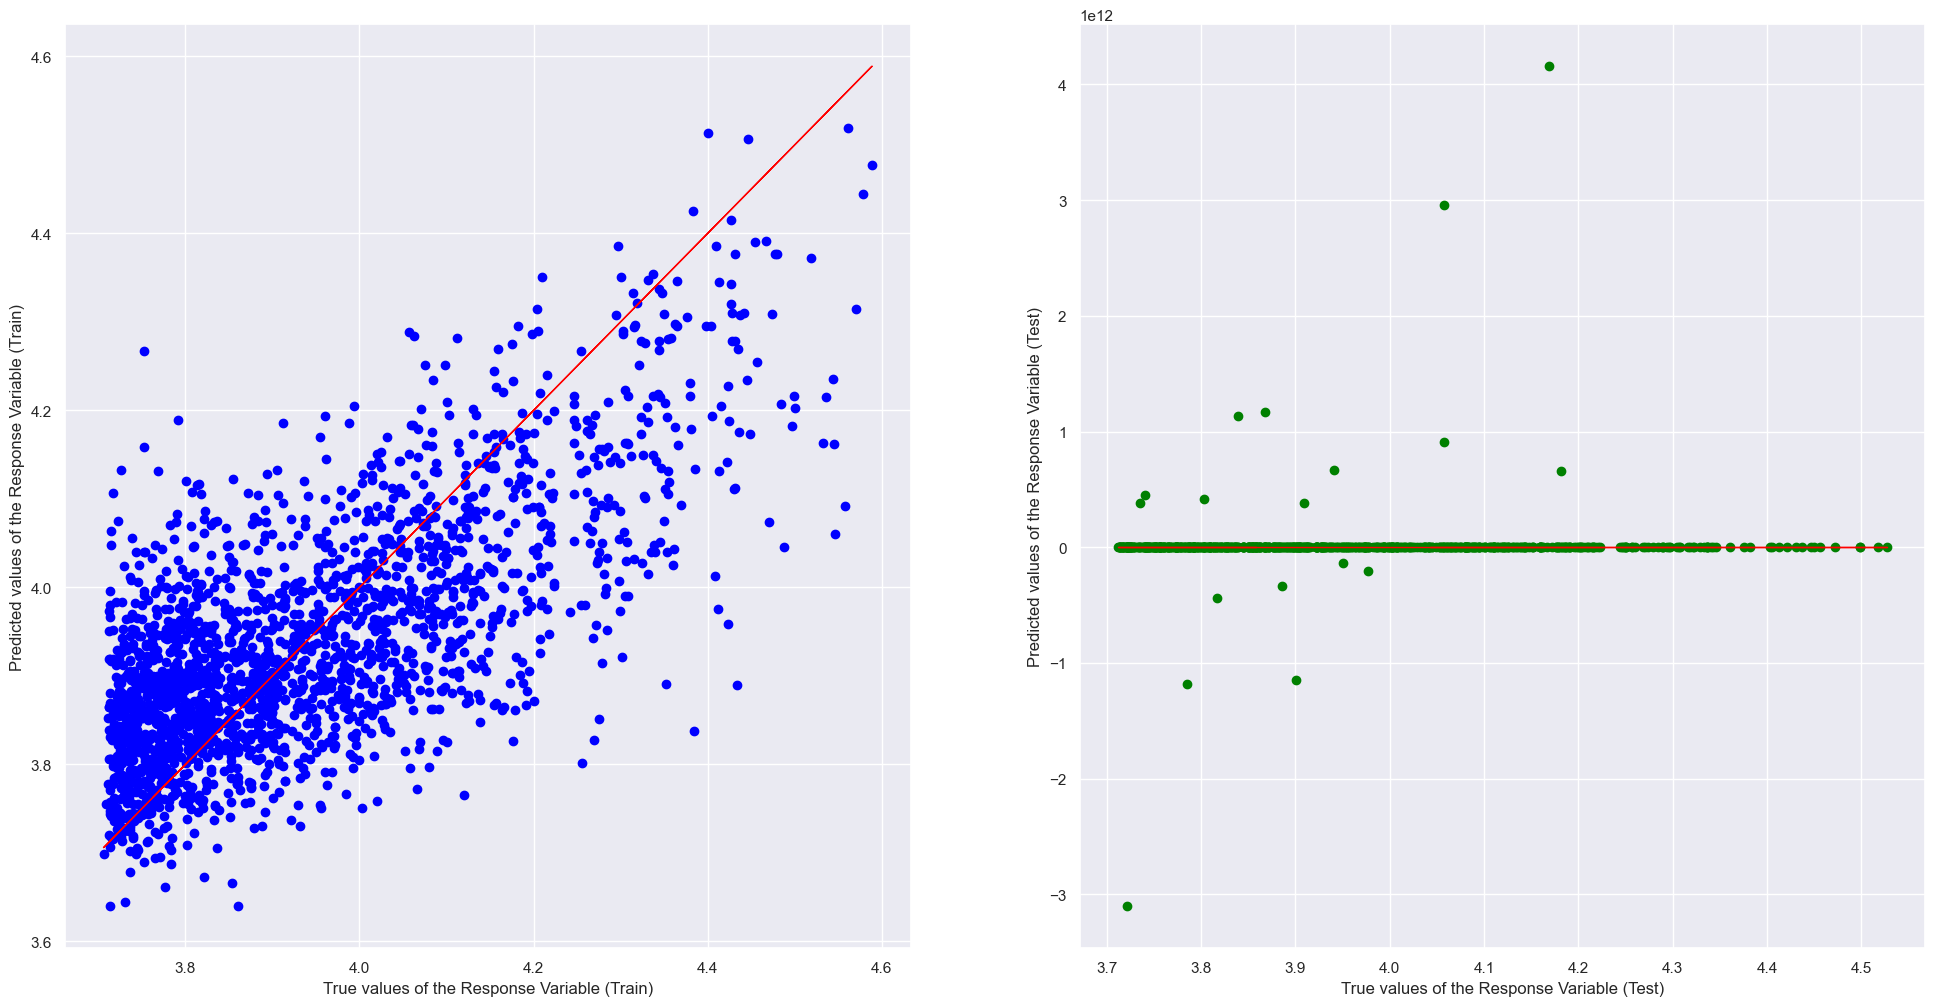

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5037244222970937
Mean Squared Error (MSE) 	: 0.017445804307792412

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -1.9220700680428653e+24
Mean Squared Error (MSE) 	: 6.1341843775997755e+22



In [67]:
#Training models for experimentation

#THIS IS WITHOUT DROPPING THE MINORITY CLASS

# Extract Response and Predictors
y = pd.DataFrame(nanashi["Rating"])
X = pd.DataFrame(nanashi.drop('Rating', axis=1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()


# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'red', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'red', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()


# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Our R^2 value for the test set is negative and MSE is quite high.
This could be due to class imbalance and overfitting. There are a number of tags that are quite niche and only have a handful of shows. As such, this could affect our model's ability to predict rating. To address this we can adopt dropping tags that appear less than 20 times.

# 2. Linear Regression (After dropping minority class)

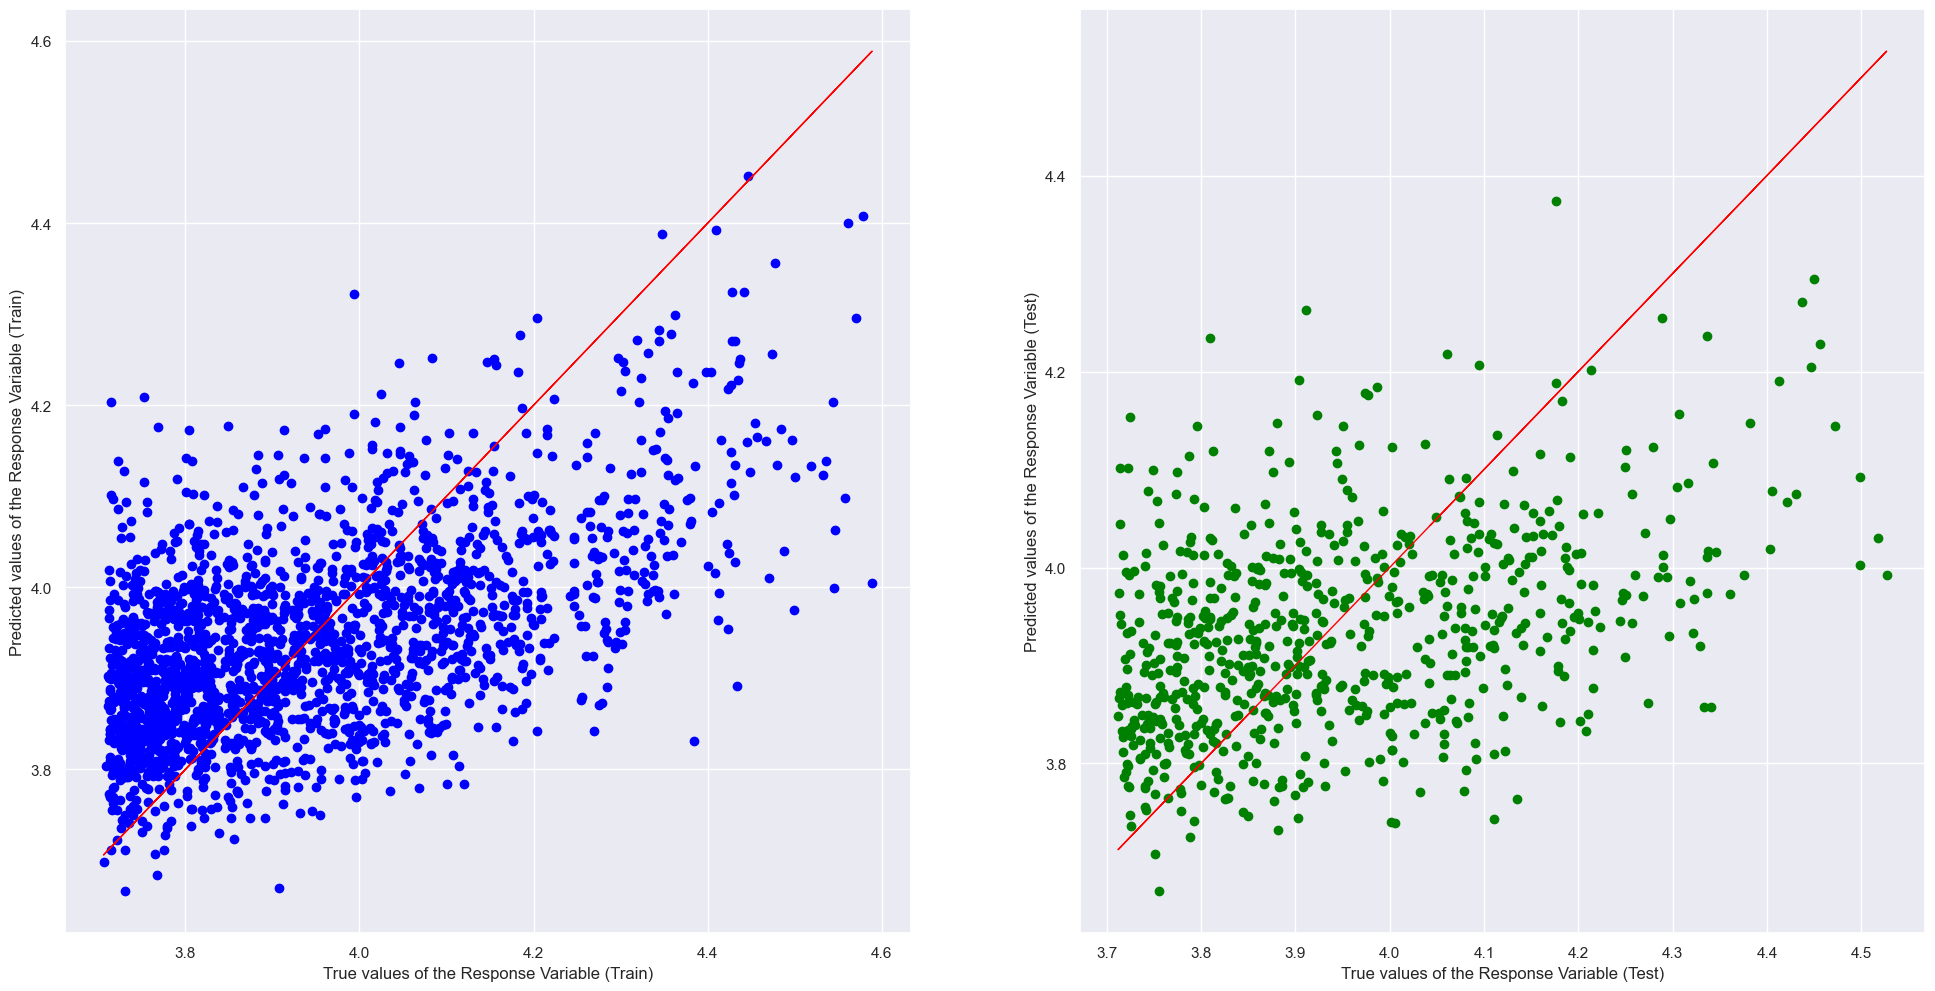

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.3209546258131334
Mean Squared Error (MSE) 	: 0.023870795272677332

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.13247532458217492
Mean Squared Error (MSE) 	: 0.02768658853602032



In [68]:
#Training models for experimentation

#MINORITY CLASS HAS BEEN DROPPED

# Extract Response and Predictors
y = pd.DataFrame(above_threshold["Rating"])
X = pd.DataFrame(above_threshold.drop('Rating', axis=1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)


# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'red', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'red', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()


# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

After dropping the minority class, our model performs slightly better, with a posiitve R^2 value and a low MSE.

# 3. MINORITY CLASS HAS BEEN DROPPED + QUANTILE TRANSFORM RATING TO FIX SKEW

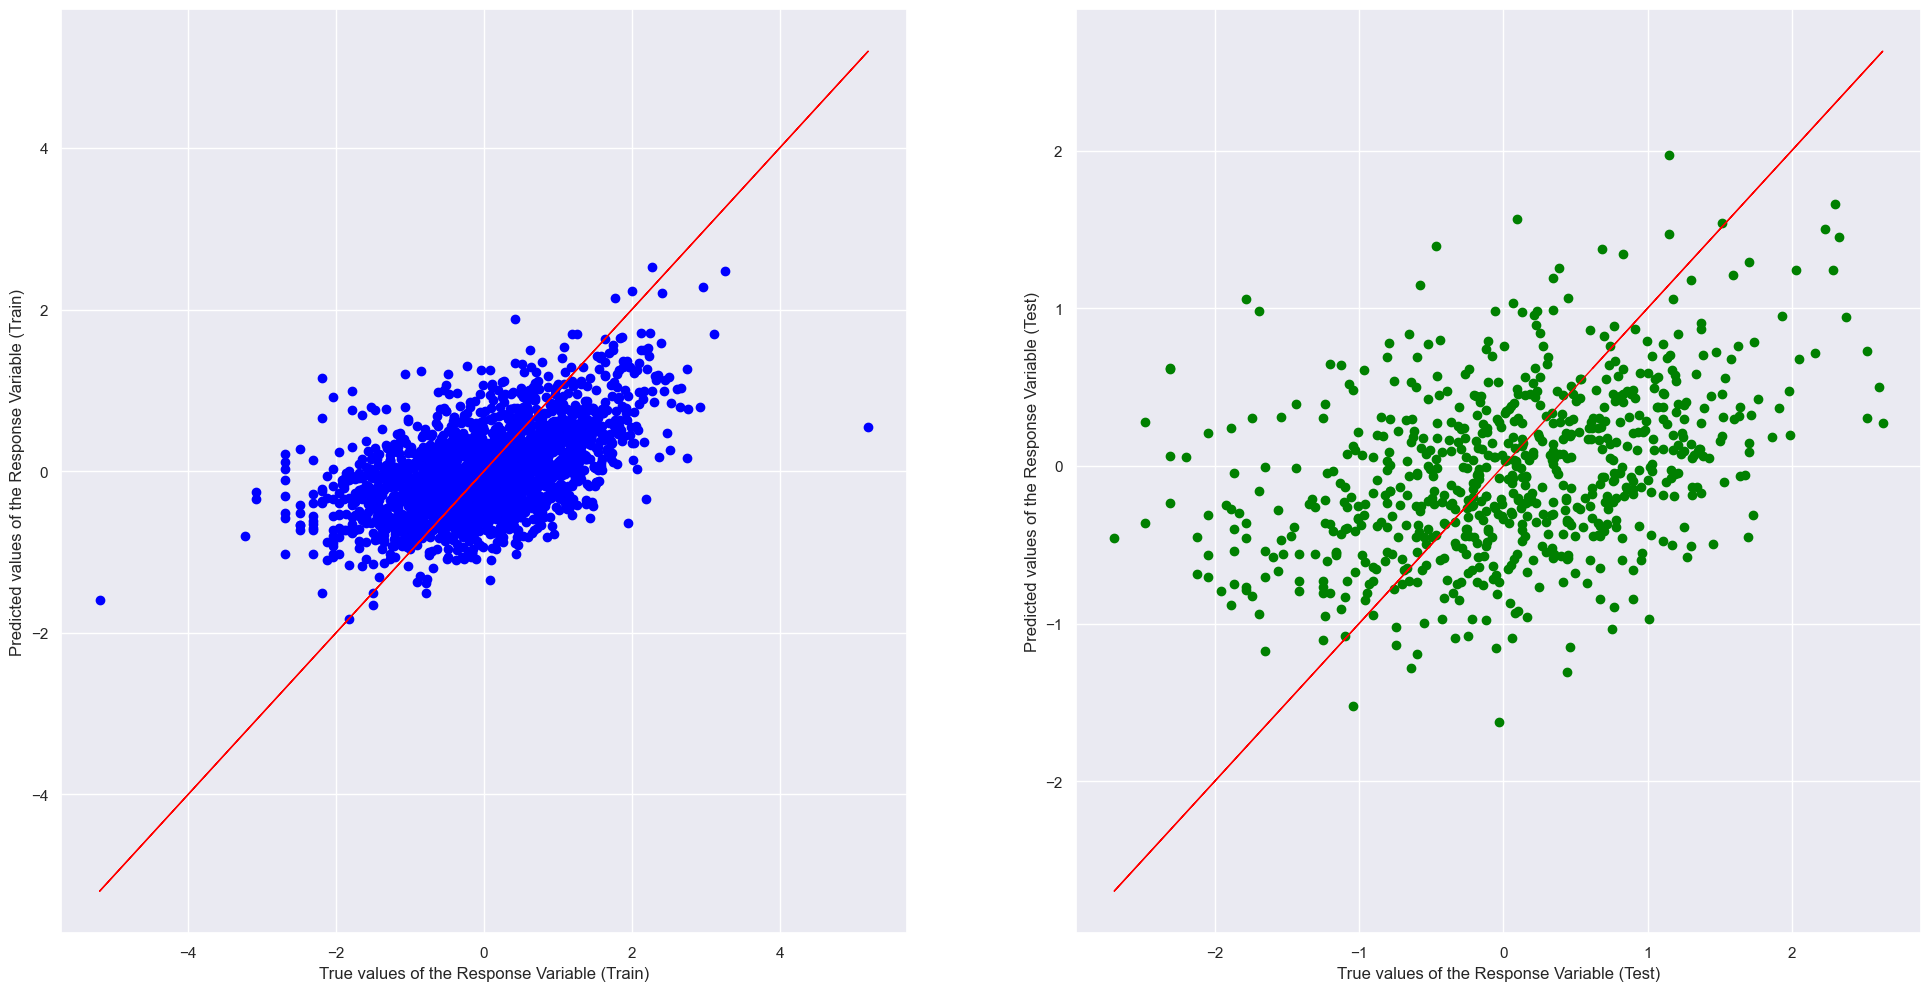

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.290304146996498
Mean Squared Error (MSE) 	: 0.7220604025642047

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.1094274178177822
Mean Squared Error (MSE) 	: 0.7931937168357002



In [69]:
#Training models for experimentation

#MINORITY CLASS HAS BEEN DROPPED + QUANTILE TRANSFORM RATING TO FIX SKEW

# Import essential models and functions from sklearn
from sklearn.preprocessing import QuantileTransformer

# Extract Response and Predictors
y = pd.DataFrame(above_threshold["Rating"])
X = pd.DataFrame(above_threshold.drop('Rating', axis=1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)

#Scaling using a transformer
quantile = QuantileTransformer(output_distribution='normal')

normalized_y_train = pd.DataFrame(
    quantile.fit_transform(y_train),
    columns = y_train.columns
)

normalized_y_test = pd.DataFrame(
    quantile.transform(y_test),
    columns = y_test.columns
)


# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, normalized_y_train)        # train the linear regression model

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)


# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(normalized_y_train, y_train_pred, color = "blue")
axes[0].plot(normalized_y_train, normalized_y_train, 'red', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(normalized_y_test, y_test_pred, color = "green")
axes[1].plot(normalized_y_test, normalized_y_test, 'red', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()


# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, normalized_y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(normalized_y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, normalized_y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(normalized_y_test, y_test_pred))
print()

# 4. MINORITY CLASS HAS BEEN DROPPED + LOG TRANSFORM RESPONSE VARIABLE

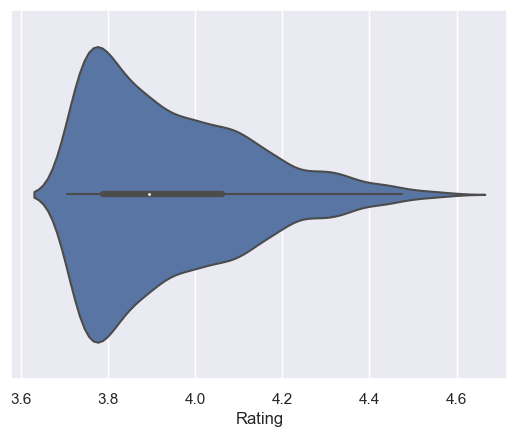

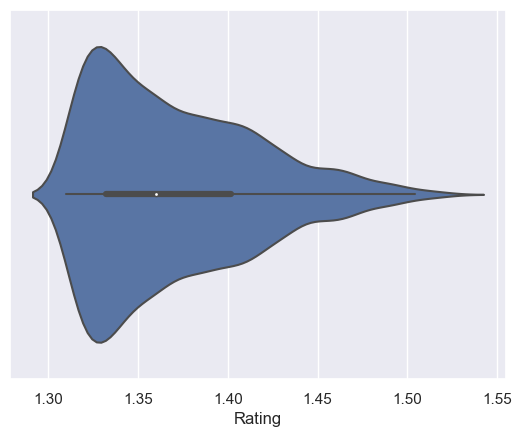

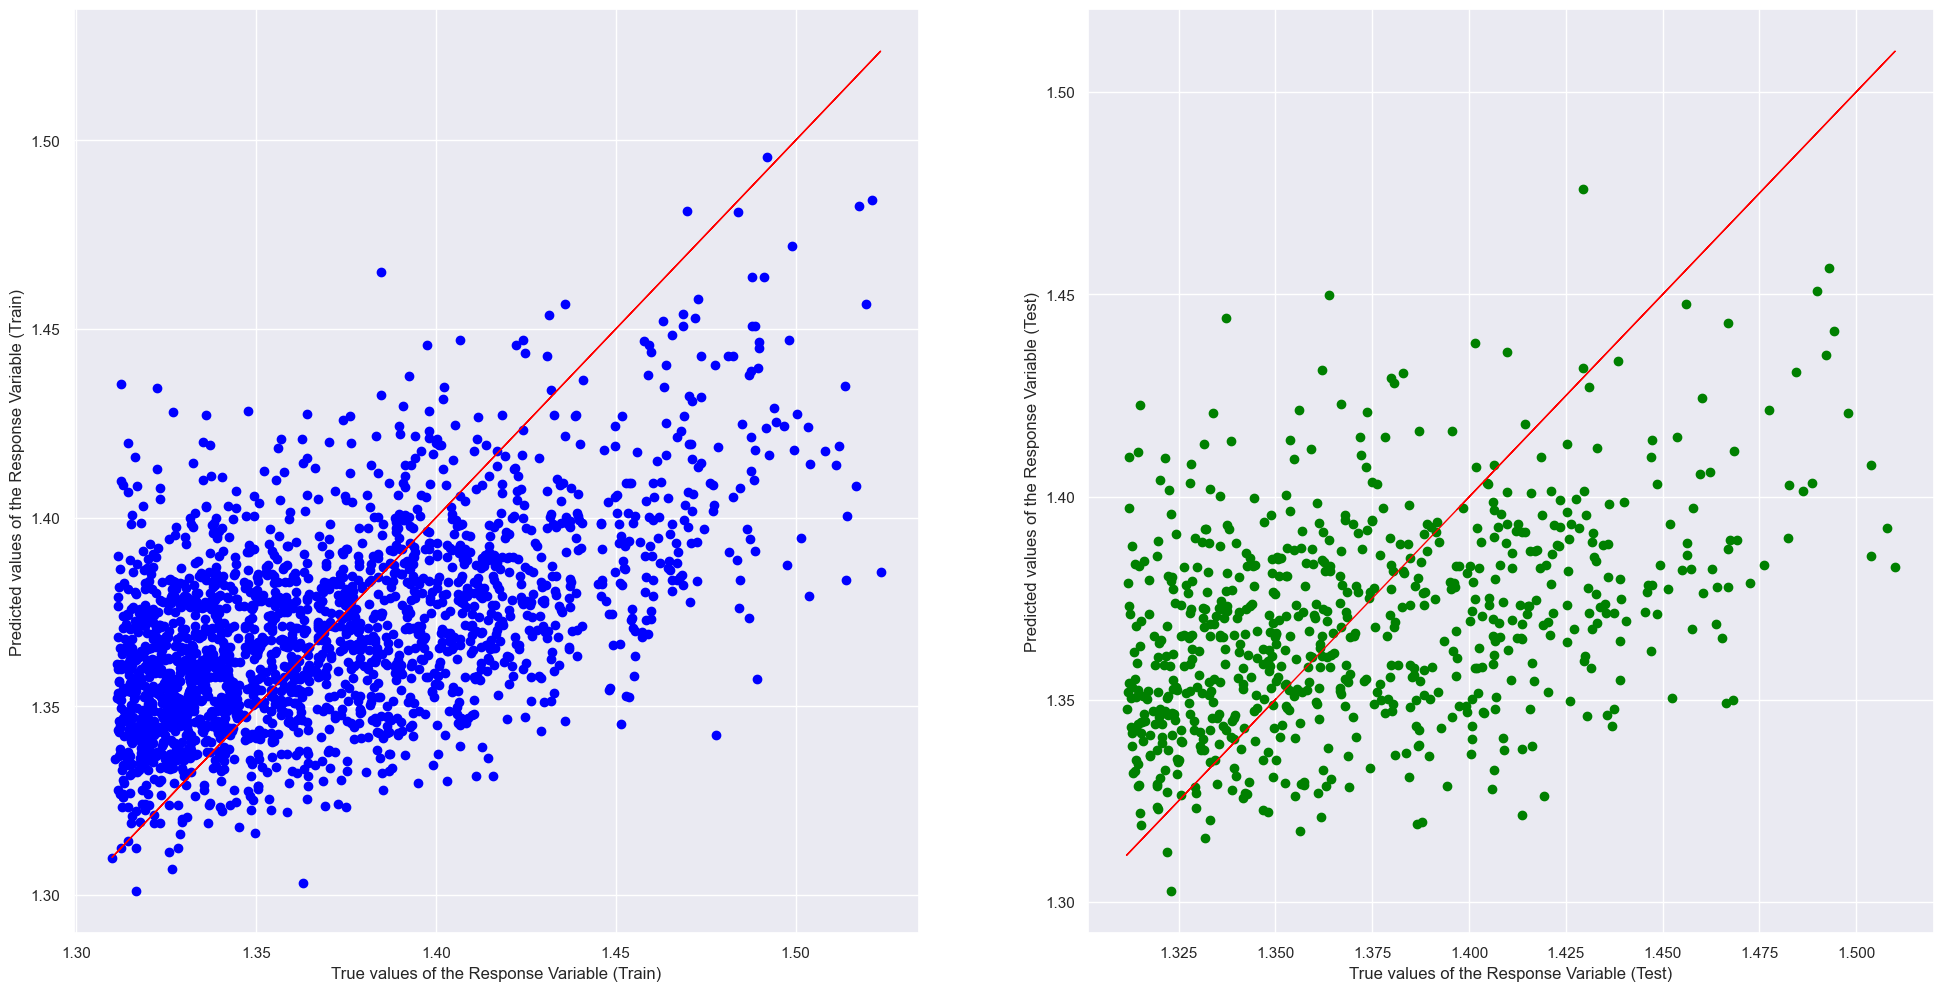

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.3182637764986559
Mean Squared Error (MSE) 	: 0.0014837815044849315

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.13191028211675349
Mean Squared Error (MSE) 	: 0.0017228188165331385



In [70]:
#Training models for experimentation

#MINORITY CLASS HAS BEEN DROPPED + LOG TRANSFORM RESPONSE VARIABLE

# Extract Response and Predictors
y = pd.DataFrame(above_threshold["Rating"])
X = pd.DataFrame(above_threshold.drop('Rating', axis=1))

#Transforming data
sb.violinplot(x=above_threshold['Rating'])
plt.show()
y = pd.DataFrame(np.log(above_threshold["Rating"]))
sb.violinplot(x=y['Rating'])
plt.show()

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)


# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'red', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'red', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()


# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# 5. MINORITY CLASS HAS BEEN DROPPED + SQRT TRANSFORM RESPONSE VARIABLE

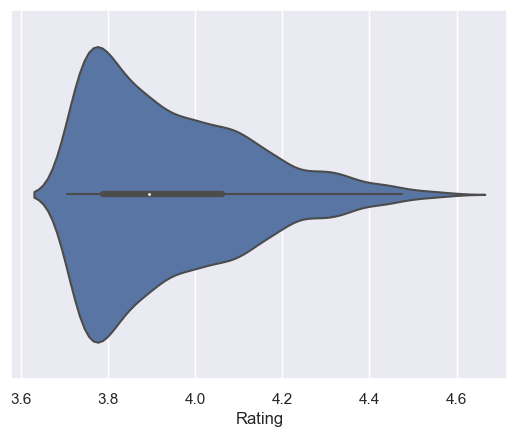

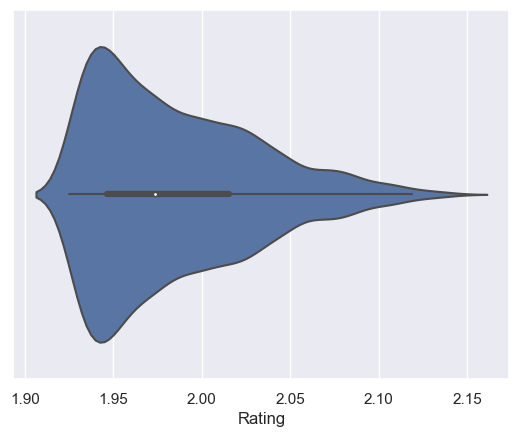

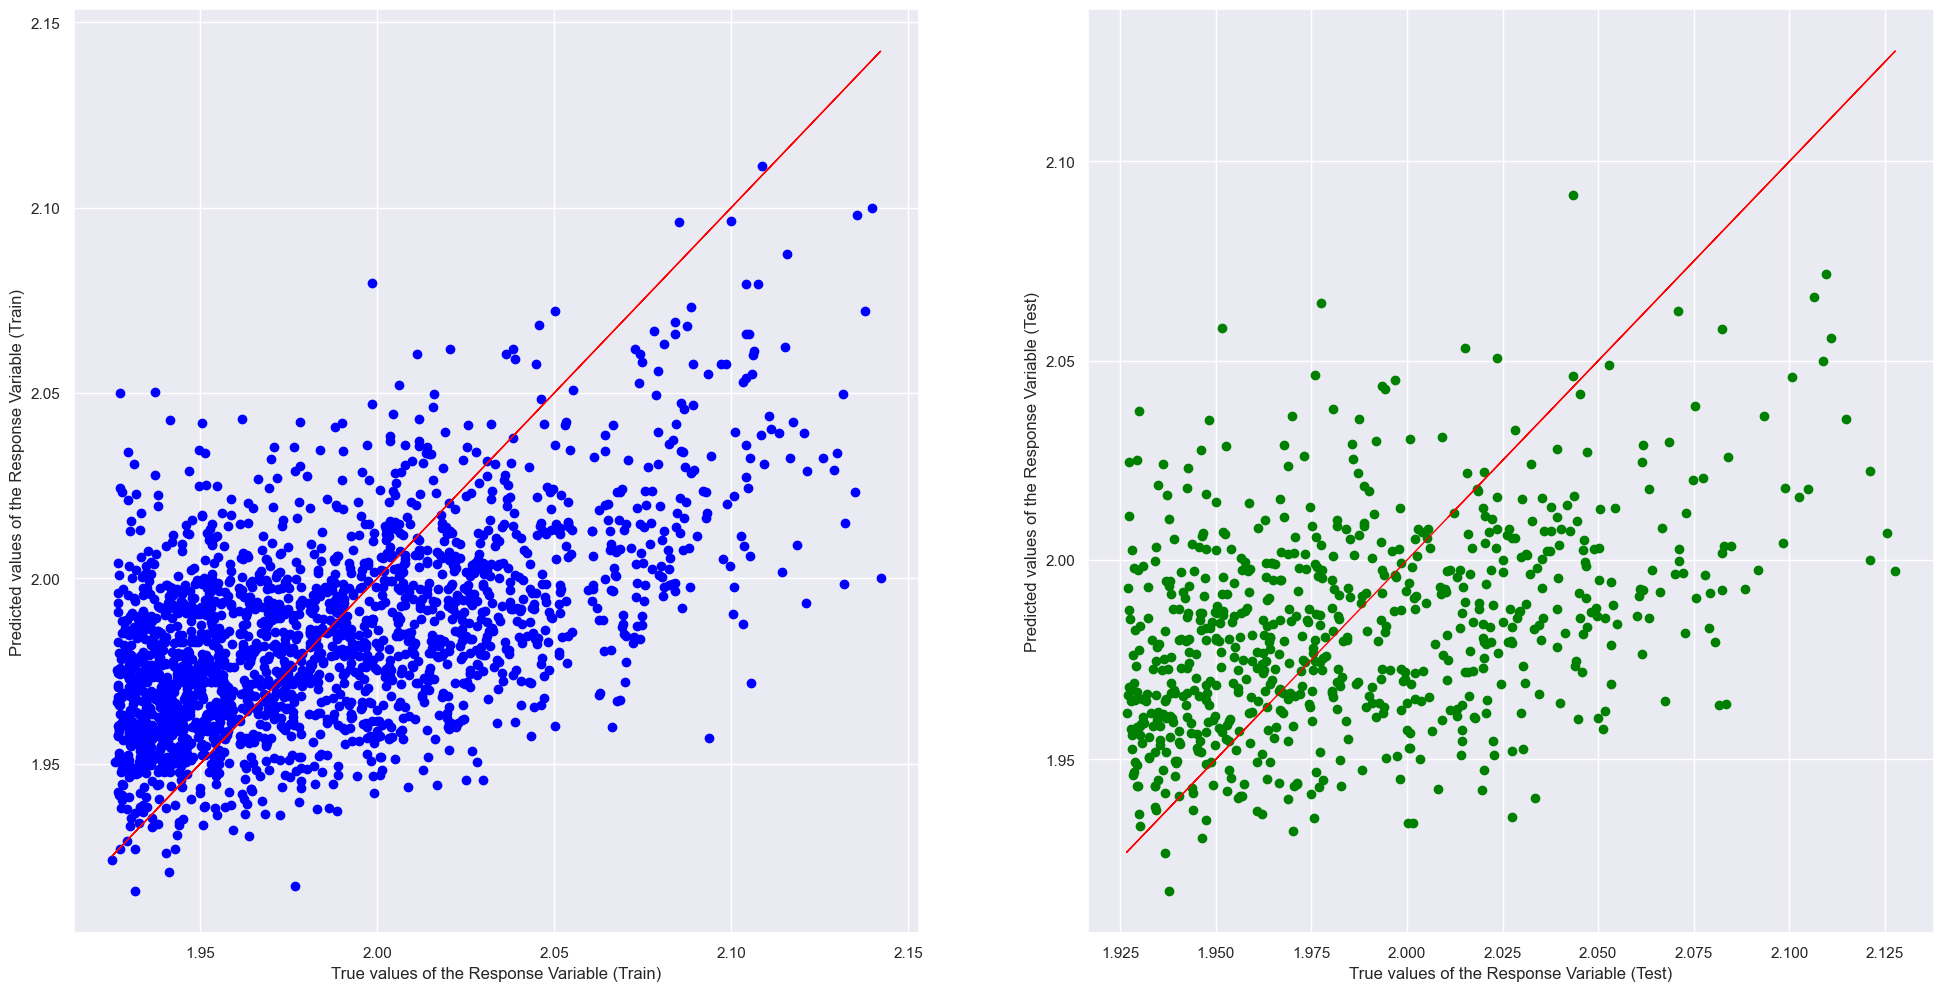

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.31963035283063457
Mean Squared Error (MSE) 	: 0.0014868761412770853

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.13221818713940092
Mean Squared Error (MSE) 	: 0.0017255892321955553



In [71]:
#Training models for experimentation

#MINORITY CLASS HAS BEEN DROPPED + SQRT TRANSFORM RESPONSE VARIABLE

# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Extract Response and Predictors
y = pd.DataFrame(above_threshold["Rating"])
X = pd.DataFrame(above_threshold.drop('Rating', axis=1))

#Transforming data
sb.violinplot(x=above_threshold['Rating'])
plt.show()
y = pd.DataFrame(np.sqrt(above_threshold["Rating"]))
sb.violinplot(x=y['Rating'])
plt.show()

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 100)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)


# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'red', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'red', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()


# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()